# 2D Image matching LDDMM


## Import required libraries

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.ion() # for drawing in real time
import nibabel as nib
import tensorflow as tf

## load images to register

In [2]:
# input image filenames here
# we will deform the atlas to match the target
atlas_image_fname = 'Adt27-55_02_Adt27-55_02_MNI.img'
target_image_fname = 'Adt27-55_03_Adt27-55_03_MNI.img'

In [3]:
# load them
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [4]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing
if '.img' == atlas_image_fname[-4:]:    
    nx = img[0].header['dim'][1:3]
    dx = img[0].header['pixdim'][1:3]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
x = [np.arange(nxi)*dxi for nxi,dxi in zip(nx,dx)]

<IPython.core.display.Javascript object>


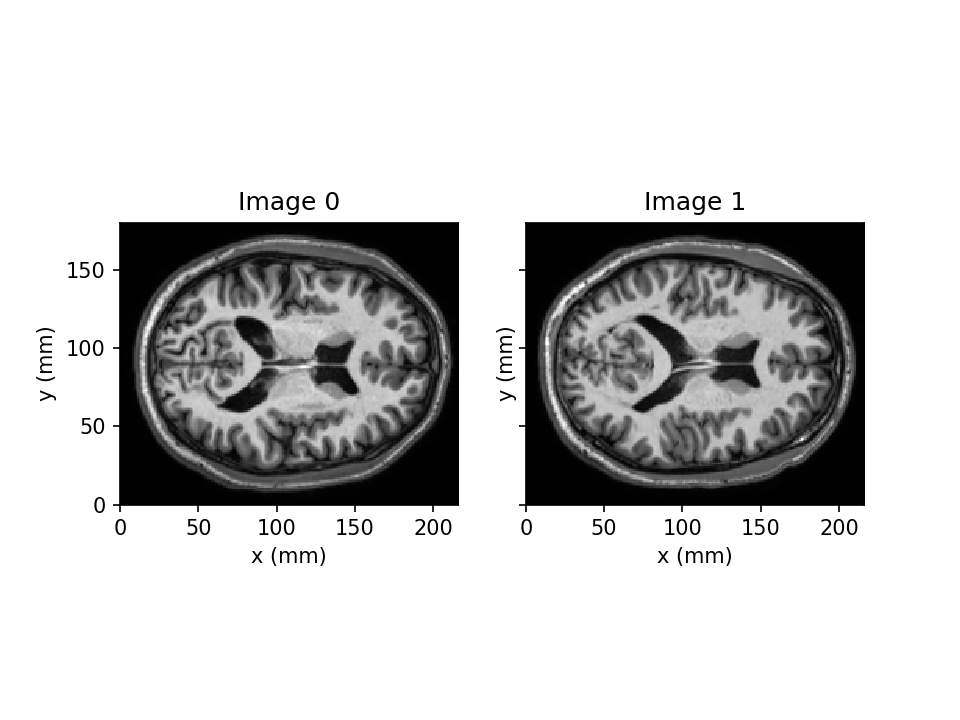

In [5]:
# get 2D slices for this example
s = int(img[0].shape[2]/2*0.96)
I,J = [i.get_data()[:,:,s,0] for i in img]
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
imopts = {'cmap':'gray','extent':(x[1][0],x[1][-1],x[0][0],x[0][-1]), 'aspect':'equal'}
ax[0].imshow(I,**imopts)
ax[1].imshow(J,**imopts)
for i,a in enumerate(ax):
    a.set_xlabel('x (mm)')
    a.set_ylabel('y (mm)')
    a.set_title('Image {}'.format(i))

## Now we need to define a linear interpolation function in tensorflow

In [6]:
def interp2(x0,x1,Itf,phi0tf,phi1tf):
    ''' 
    Linear interpolation
    Interpolate a 2D tensorflow image Itf
    with voxels corresponding to locations in x0, x1 (1d arrays)
    at the points phi0tf, phi1tf (2d arrays)
    '''
    # get the size
    dx = [x0[1]-x0[0], x1[1]-x1[0]]
    nx = [len(x0), len(x1)]    
    #convert to index
    phi0_index = (phi0tf - x0[0])/dx[0]
    phi1_index = (phi1tf - x1[0])/dx[1]
    # take the floor to get integers
    phi0_index_floor = tf.floor(phi0_index)
    phi1_index_floor = tf.floor(phi1_index)
    # get the fraction to the next pixel
    phi0_p = phi0_index - phi0_index_floor
    phi1_p = phi1_index - phi1_index_floor
    # get the next samples
    phi0_index_floor_1 = phi0_index_floor+1
    phi1_index_floor_1 = phi1_index_floor+1
    # and apply boundary conditions
    phi0_index_floor = tf.minimum(phi0_index_floor,nx[0]-1)
    phi0_index_floor = tf.maximum(phi0_index_floor,0)
    phi0_index_floor_1 = tf.minimum(phi0_index_floor_1,nx[0]-1)
    phi0_index_floor_1 = tf.maximum(phi0_index_floor_1,0)
    phi1_index_floor = tf.minimum(phi1_index_floor,nx[1]-1)
    phi1_index_floor = tf.maximum(phi1_index_floor,0)
    phi1_index_floor_1 = tf.minimum(phi1_index_floor_1,nx[1]-1)
    phi1_index_floor_1 = tf.maximum(phi1_index_floor_1,0)
    # then we will need to vectorize everything to use scalar indices
    phi0_index_floor_flat = tf.reshape(phi0_index_floor,[-1])
    phi0_index_floor_flat_1 = tf.reshape(phi0_index_floor_1,[-1])
    phi1_index_floor_flat = tf.reshape(phi1_index_floor,[-1])
    phi1_index_floor_flat_1 = tf.reshape(phi1_index_floor_1,[-1])
    I_flat = tf.reshape(Itf,[-1])
    # indices recall that the LAST INDEX IS CONTIGUOUS
    phi_index_floor_flat_00 = nx[1]*phi0_index_floor_flat + phi1_index_floor_flat
    phi_index_floor_flat_01 = nx[1]*phi0_index_floor_flat + phi1_index_floor_flat_1
    phi_index_floor_flat_10 = nx[1]*phi0_index_floor_flat_1 + phi1_index_floor_flat
    phi_index_floor_flat_11 = nx[1]*phi0_index_floor_flat_1 + phi1_index_floor_flat_1
    # now slice the image
    I00_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_00, dtype=tf.int64))
    I01_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_01, dtype=tf.int64))
    I10_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_10, dtype=tf.int64))
    I11_flat = tf.gather(I_flat, tf.cast(phi_index_floor_flat_11, dtype=tf.int64))
    # reshape it
    I00 = tf.reshape(I00_flat,nx[:2])
    I01 = tf.reshape(I01_flat,nx[:2])
    I10 = tf.reshape(I10_flat,nx[:2])
    I11 = tf.reshape(I11_flat,nx[:2])
    # combine them!
    Il = I00*(1.0-phi0_p)*(1.0-phi1_p) \
        + I01*(1.0-phi0_p)*(    phi1_p) \
        + I10*(    phi0_p)*(1.0-phi1_p) \
        + I11*(    phi0_p)*(    phi1_p)
    return Il

## and we need a gradient function

In [7]:
def grad2(Itf,dx):
    I_0 = (tf.manip.roll(Itf,shift=-1,axis=0) - tf.manip.roll(Itf,shift=1,axis=0))/2.0/dx[0]
    I_1 = (tf.manip.roll(Itf,shift=-1,axis=1) - tf.manip.roll(Itf,shift=1,axis=1))/2.0/dx[1]
    #out[0,:] = out[1,:]-out[0,:] # this doesn't work in tensorflow
    # generally you cannot assign to a tensor
    return I_0, I_1

## Now we set some parameters

In [8]:
# gradient descent stepsize this will be a placeholder
# each time we will take a gradient descent step
# we may want to change it from time to time
epsilon = 1e-1
epsilonph = tf.placeholder(tf.float32, shape=()) 
niter = 20 # number of optimization iterations

# flow parameters
nt = 5 # number of timesteps
dt = 1.0/nt # increment in time for each step
alpha = dx[0]*2.0 # spatial scale of smoothing operator
power = 2.0 # power of identity - alpha*Laplacian

# cost parameters
sigmaM = (np.max(J) - np.min(J))*0.1 # matching cost standard deviation, smaller means larger cost
sigmaM = 1e1
sigmaR = 1e0 # regularization cost standard deviation

## build a fourier domain and differential operators

In [9]:
f0 = np.arange(nx[0])/dx[0]/nx[0]
f1 = np.arange(nx[1])/dx[1]/nx[1]
F0,F1 = np.meshgrid(f0, f1, indexing='ij')
# identity minus laplacian, in fourier domain
# AI[i,j] = I[i,j] - alpha^2( (I[i+1,j] - 2I[i,j] + I[i-1,j])/dx^2 + (I[i,j+1] - 2I[i,j] + I[i,j-1])/dy^2  )
Lhat = (1.0 - alpha**2*((-2.0 + 2.0*np.cos(2*np.pi*dx[0]*F0))/dx[0]**2 
    + (-2.0 + 2.0*np.cos(2*np.pi*dx[1]*F1))/dx[1]**2   ))**power
# for real ffts we only half of this, TODO
LLhat = Lhat**2
Khat = 1.0/LLhat
# convert to tensorflow
Khattf = tf.complex(tf.constant(Khat,dtype=tf.float32),0.)
#LLhattf = tf.complex(tf.constant(LLhat,dtype=tf.float32),0.)
LLhattf = tf.constant(LLhat,dtype=tf.float32)

## initialize my optimization variables
Each iteration there will be an old version and a new versoin

In [10]:
# NOTE this cell can only be run once
# if you run it again it will generate errors
vt0 = tf.get_variable('vt0',shape=[nx[0],nx[1],nt],dtype=tf.float32,trainable=False,initializer=tf.zeros_initializer())
vt1 = tf.get_variable('vt1',shape=[nx[0],nx[1],nt],dtype=tf.float32,trainable=False,initializer=tf.zeros_initializer())
vt0new = tf.get_variable('vt0new',shape=[nx[0],nx[1],nt],dtype=tf.float32,trainable=False,initializer=tf.zeros_initializer())
vt1new = tf.get_variable('vt1new',shape=[nx[0],nx[1],nt],dtype=tf.float32,trainable=False,initializer=tf.zeros_initializer())

## Implement the tensorflow graph for one iteration of gradient descent

In [11]:
# initialize some variables
Itf = tf.constant(I,dtype=tf.float32)
Jtf = tf.constant(J,dtype=tf.float32)
x0=x[0]
x1=x[1]
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
X0tf = tf.constant(X0,dtype=tf.float32)
X1tf = tf.constant(X1,dtype=tf.float32)

In [12]:
# flow forwards
It = [Itf]
phiinv0 = X0tf
phiinv1 = X1tf
#ER = 0.0 # I think maybe there is a problem with the way I'm doing this, it may be continuing to accumulate
for t in range(nt):
    v0 = vt0[:,:,t]
    v1 = vt1[:,:,t]
    X0s = X0 - v0*dt
    X1s = X1 - v1*dt
    
    # update diffeomorphism with nice boundary conditions
    phiinv0 = interp2(x0,x1,phiinv0-X0tf,X0s,X1s)+X0s
    phiinv1 = interp2(x0,x1,phiinv1-X1tf,X0s,X1s)+X1s
    
    # deform the image
    It.append(interp2(x0,x1,Itf,phiinv0,phiinv1))
    
    # get regularization energy
    # this is probably the fastest way to compute energy, note the normalizer 1/(number of elemetns)
    v0hat = tf.fft2d(tf.complex(v0,0.0))
    v1hat = tf.fft2d(tf.complex(v1,0.0))
    ERt = tf.reduce_sum( ( tf.abs(v0hat)**2 + tf.abs(v1hat)**2 ) * LLhattf )
    if t==0:
        ER = ERt
    else:
        ER = ER + ERt
ER = ER*dt*dx[0]*dx[1]/sigmaR**2/2.0/nx[0]/nx[1]

# now compute the error
lambda1 = (It[-1] - J)/sigmaM**2

# get matching energy 
EM = tf.reduce_sum((It[-1] - J)**2)/sigmaM**2*dx[0]*dx[1]/2.0
E = EM + ER

# flow the error backwards
phiinv0 = X0tf
phiinv1 = X1tf
vt0new_ = []
vt1new_ = []
for t in range(nt-1,-1,-1):
    v0 = vt0[:,:,t]
    v1 = vt1[:,:,t]
    X0s = X0 + v0*dt
    X1s = X1 + v1*dt
    phiinv0 = interp2(x0,x1,phiinv0-X0,X0s,X1s) + X0s
    phiinv1 = interp2(x0,x1,phiinv1-X1,X0s,X1s) + X1s
    
    # compute the gradient of the image at this time
    I_0,I_1 = grad2(It[t],dx)
    
    # compute the determinanat of jacobian
    phiinv0_0,phiinv0_1 = grad2(phiinv0,dx)
    phiinv1_0,phiinv1_1 = grad2(phiinv1,dx)
    detjac = phiinv0_0*phiinv1_1 - phiinv0_1*phiinv1_0
    
    # get the lambda for this time
    lambda_ = interp2(x0,x1,lambda1,phiinv0,phiinv1)*detjac
    
    # set up the gradient
    grad0 = -lambda_*I_0
    grad1 = -lambda_*I_1
    
    # smooth it
    grad0 = tf.real(tf.ifft2d(tf.fft2d(tf.complex(grad0,0.0))*Khattf))
    grad1 = tf.real(tf.ifft2d(tf.fft2d(tf.complex(grad1,0.0))*Khattf))
    
    # add the regularization
    grad0 = grad0 + v0/sigmaR**2
    grad1 = grad1 + v1/sigmaR**2
    
    # and calculate the new v
    vt0new_.append(v0 - epsilonph*grad0)
    vt1new_.append(v1 - epsilonph*grad1)

# stack
vt0new = tf.stack(vt0new_[::-1],axis=2)
vt1new = tf.stack(vt1new_[::-1],axis=2)

# define a graph operation
step = tf.group(
  vt0.assign(vt0new),
  vt1.assign(vt1new))

<IPython.core.display.Javascript object>


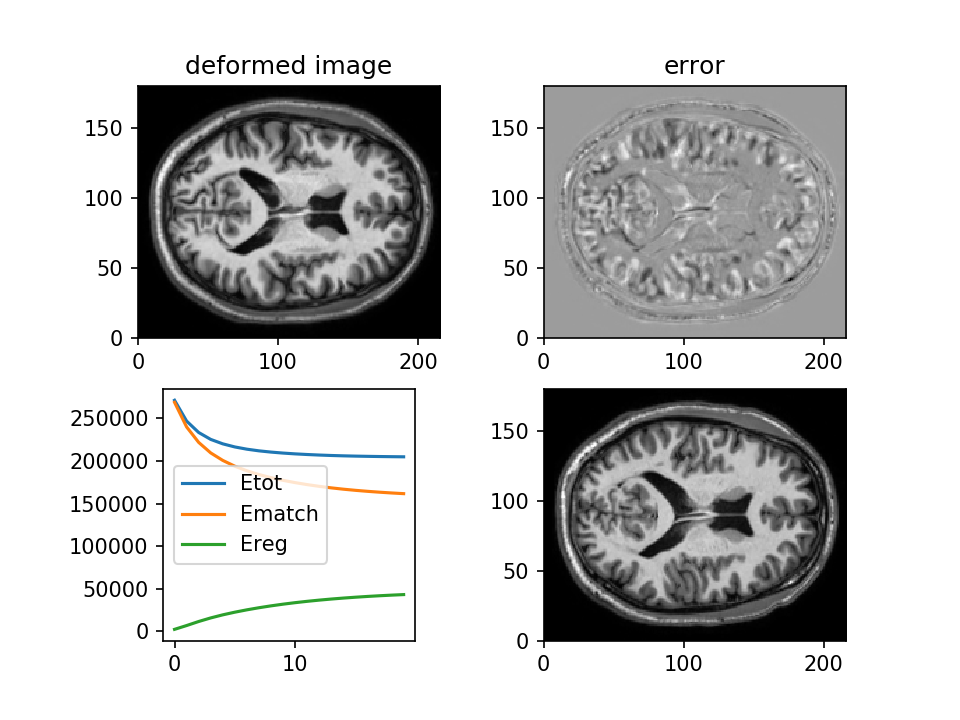

In [13]:
EMall = []
ERall = []
Eall = []
f,ax = plt.subplots(2,2)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(niter):
        # take a step of gradient descent
        step.run({epsilonph:epsilon})
        
        Idnp = It[-1].eval()
        ax[0][0].imshow(Idnp,**imopts)
        ax[0][0].set_title('deformed image'.format(i))
        
        lambda1np = lambda1.eval()
        ax[0][1].imshow(lambda1np,**imopts)
        ax[0][1].set_title('error')
        
        EMall.append(EM.eval())
        ERall.append(ER.eval())
        Eall.append(E.eval())
        ax[1][0].cla()
        ax[1][0].plot(list(zip(Eall,EMall,ERall)))
        xlim = ax[1][0].get_xlim()
        ylim = ax[1][0].get_ylim()
        ax[1][0].set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
        ax[1][0].legend(['Etot','Ematch','Ereg'])
        
        ax[1][1].imshow(J,**imopts)
        
        f.canvas.draw()
        f.savefig('lddmm2d_example_iteration_{:03d}.png'.format(i))